# Week 5 Solutions

## Reading questions

1. _Dynamical friction_ refers to the drag force felt by a body moving through a background of particles. The particles are deflected by the gravity of the body, reducing their head-on velocity. Momentum conservation then implies that the body must experience a deceleration.

2. The quantity $h(v)$ is referred to as a "potential" (the Rosenbluth potential) because the force experienced by the body is proportional to the gradient of $h$, albeit a gradient in velocity space rather than real space. For a spherical distribution of mass, we know that need consider only the mass with radius $r$ to calculate the gravitational field at $r$. Similarly, for an isotropic velocity field, we need consider only velocities $v<v_M$ to calculate the force.

3. The dynamical time $t_\mathrm{dyn}$ can be evaluated as the crossing time $2\pi R/v$ (e.g. see above equation 5.9). The Coulomb logarithm term can be evaluated using equation (19.33), $\Lambda = b_\mathrm{max}v_\mathrm{typ}^2/G(M+m)$. As described in the text, a common approach is to set $b_\mathrm{max}$ equal to the orbital radius of the body, and then $v_\mathrm{typ}$ would be a typical velocity of a particle in the cluster.

4. The Kirsh et al. paper shows that a planet in a planetesimal disk tends to migrate inwards with a rate that is independent of the mass of the planet (as long as the planet mass is small enough). The rate is given in the abstract as $${da\over dt} = {a\over T} {4\pi\Sigma a^2\over M_\star}$$ where $T$ is the planet's orbital period, and $\Sigma$ the surface density of the disk.

5. As described in section 2.1, the feeding zone is determined by finding the value of the Tisserand parameter $C_T$ (eq. 3) at the outer edge $r=a_P+3.5 r_H$. This value of $C_T$ then determines the inner and outer boundaries of the feeding zone.

6. The _Hill eccentricity_ is the eccentricity of a planetesimal's orbit divided by the _Hill factor_ $\chi = R_H/a_P = (M_P/3M_\star)^{1/3}$. It is useful because a value of $e_H\approx 1$ indicates that the radial excursion of a planetesimal on its orbit is $\approx r_H$ (since $ae = a e_H \chi = R_H e_H$). So large $e_H$ means that a planetesimal is not guaranteed to encounter the planet even if it has a similar semi-major axis.

7. In Figure 4, we can see a clump of planetesimals within a distance $r_H$ from the planet, these objects are on horseshoe orbits and protected from strongly interacting with the planet. The vertical spikes are planetesimals at the edge of the feeding zone that are being scattered to high eccentricity, conserving $C_T$.

## Planetesimal disk

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rebound
import time
import numpy as np
import random

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
def show_progress(i):
    # shows progress
    print(".", end="", flush=True)
    if not (i+1)%80:
        print() # start a new line
    return

In [3]:
def setup_disk(N=10000, mass=1e-2):
    # initialize a disk of planetesimals
    # random positions on circular orbits
    for i in range(N):
        r = np.random.uniform(0.3, 3.0)
        theta = np.random.uniform(0, 2*np.pi)
        sim.add(
            # The planetesimal mass is adjusted to get the correct disk mass
            m=mass/N,
            # put the particle on a circular orbit
            x=r*np.cos(theta),
            y=r*np.sin(theta),
            vx=-np.sin(theta)/np.sqrt(r),
            vy=np.cos(theta)/np.sqrt(r)
        )
    return

................................................................................
................................................................................
........................................
Sim time = 155.296 s
Making plots:
................................................................................
................................................................................
........................................

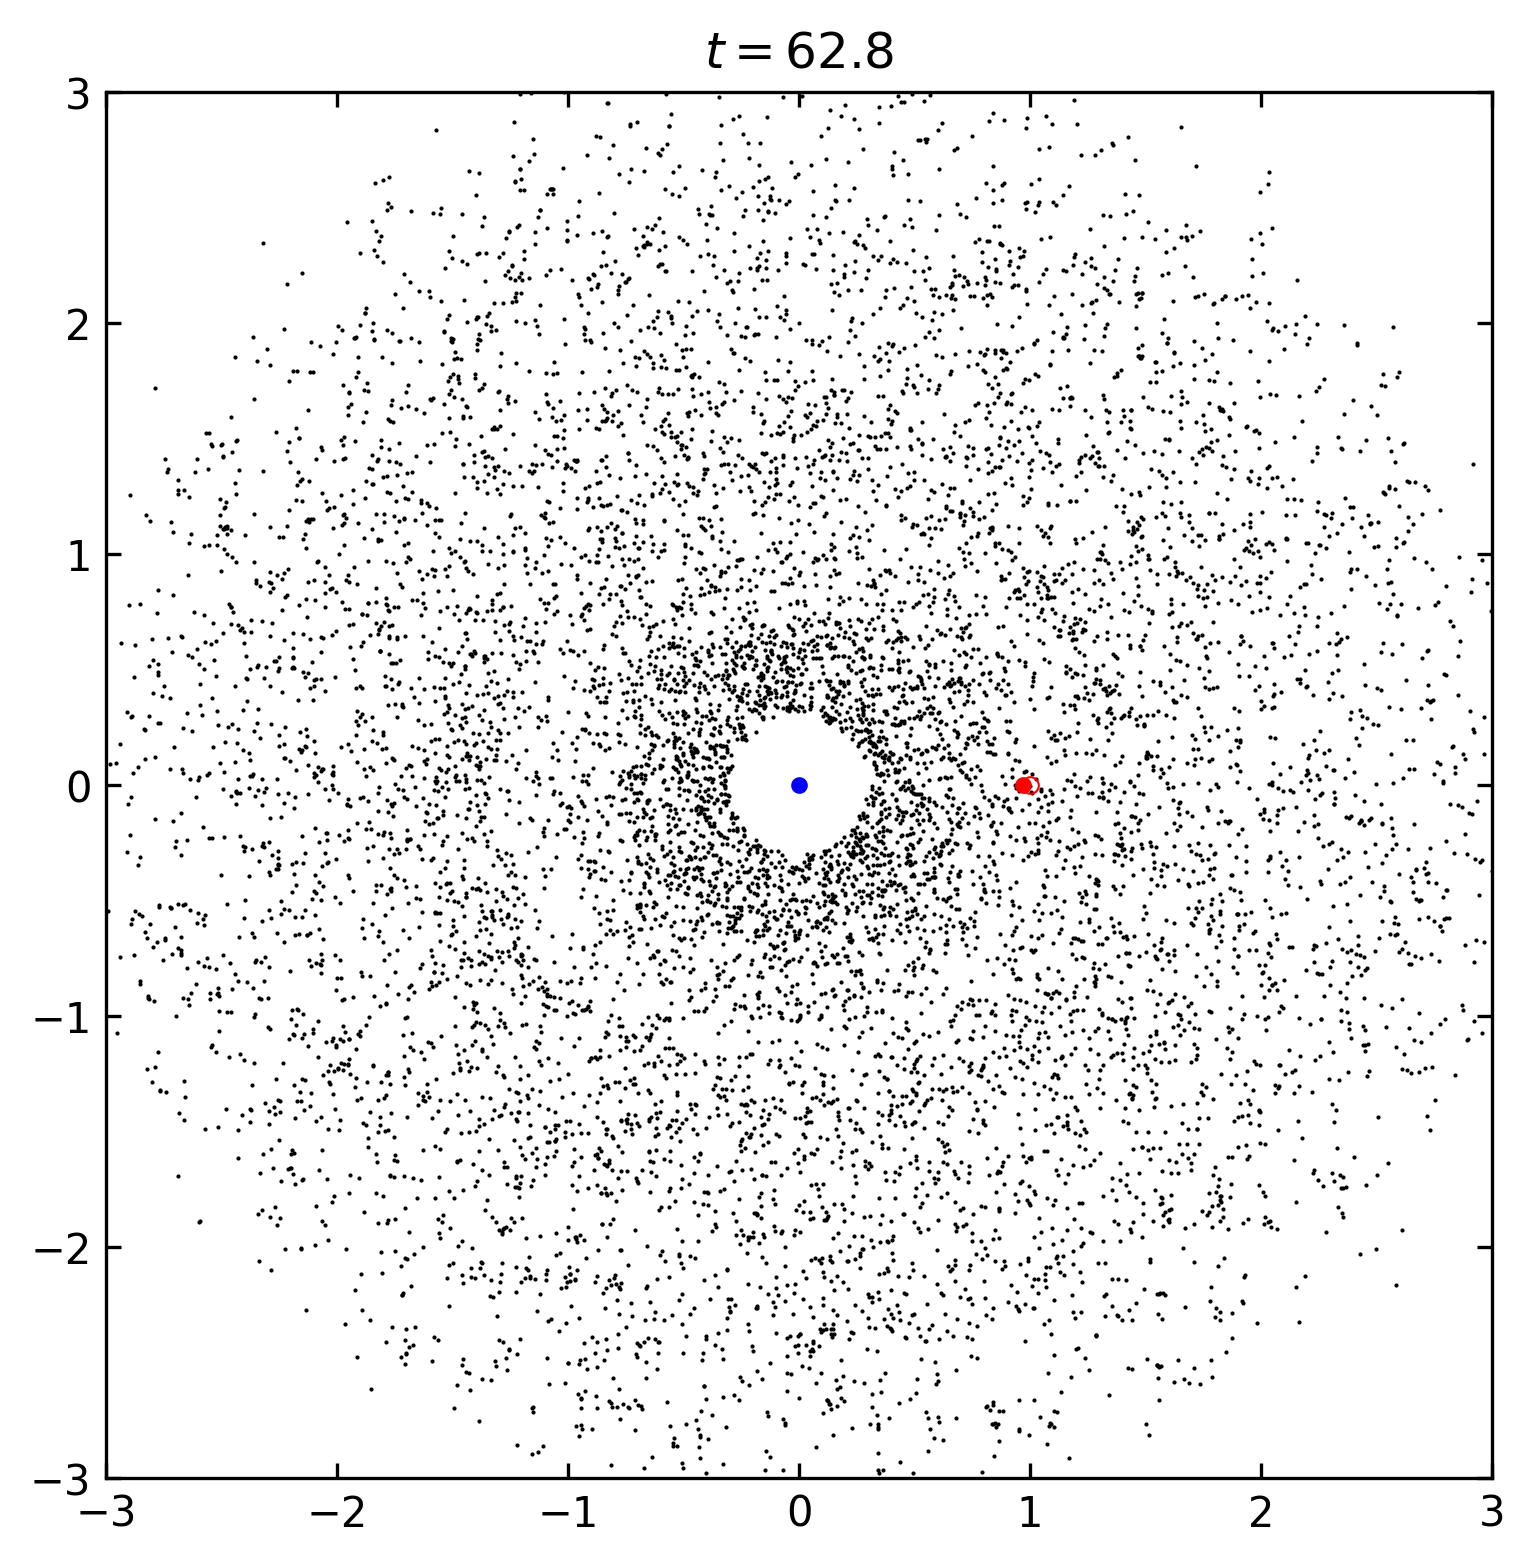

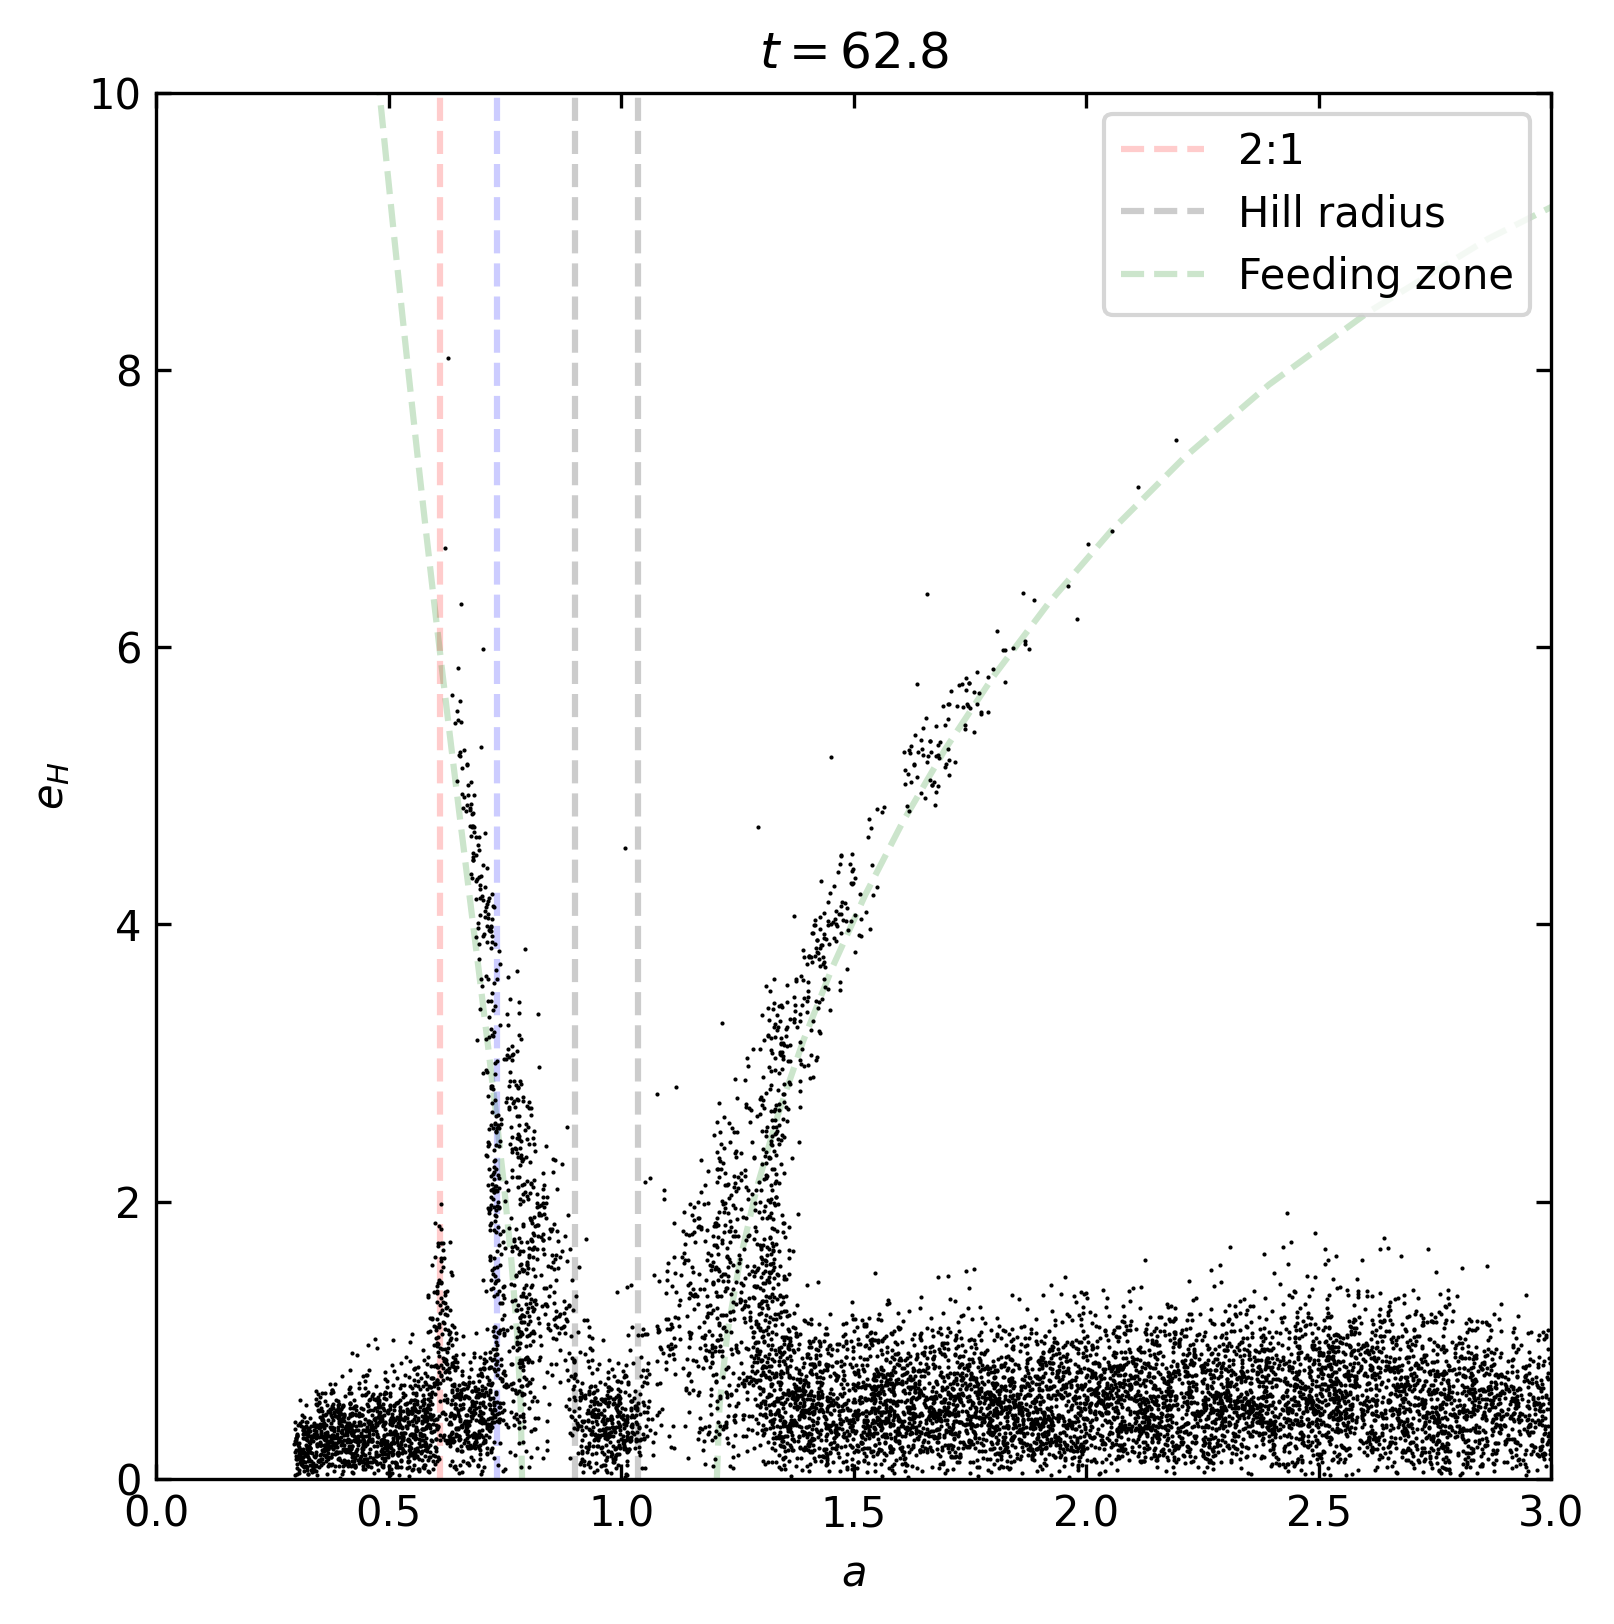

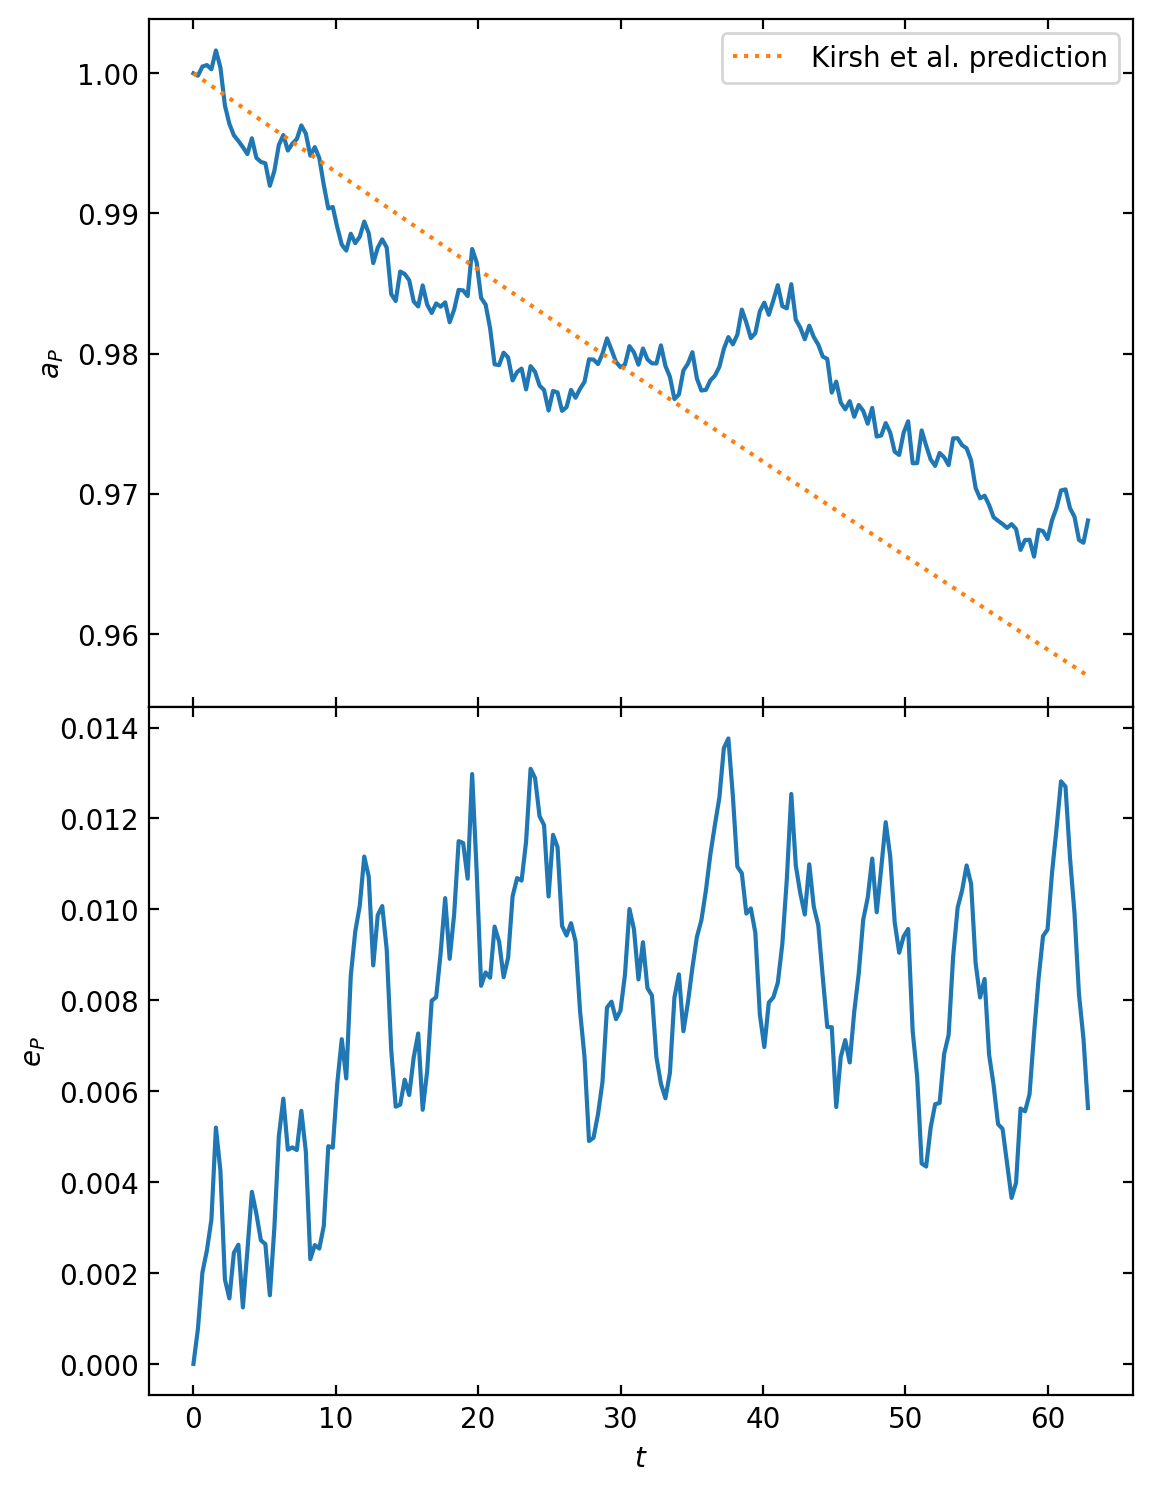

Total time = 180.424 s


In [5]:
start = time.time()

sim = rebound.Simulation()

# start the visualization server: in your browser go to http://localhost:1234
sim.start_server(port=1234)

# use a tree code since we will have many particles
sim.integrator = "leapfrog"
sim.gravity = "tree"
sim.dt = 0.01
# soften the interaction for close approaches
sim.softening = 0.01

# define a box size for the simulation and add "open" boundary conditions
# particles that leave the box will be removed
boxsize = 10
sim.configure_box(boxsize)
sim.boundary = "open"

# Star
# we'll use a hash to label it so we can find it later
sim.add(m=1.0, hash="star")

# Planet
mp = 1e-3
sim.add(m=mp, a=1.0, e=0.0, hash="planet")
# The Hill factor from Kirsh et al.
chi = (mp/3)**(1/3)

# Planetesimals
Nparticles = 10000
mdisk = 1e-2
setup_disk(N=Nparticles, mass=mdisk)

sim.move_to_com()

Noutputs = 200
Norbits = 10
times = np.linspace(0, Norbits * 2*np.pi, Noutputs)
dt = times[-1]/(Noutputs-1)
xy = np.zeros((Noutputs, Nparticles+2, 2))
ae = np.zeros((Noutputs, Nparticles+2, 2))
a = np.zeros(Noutputs)
e = np.zeros(Noutputs)
xs = np.zeros(Noutputs)
ys = np.zeros(Noutputs)
xp = np.zeros(Noutputs)
yp = np.zeros(Noutputs)
theta = np.zeros(Noutputs)
for i,t in enumerate(times):
    sim.integrate(t, exact_finish_time=1)
    show_progress(i)
    # store the star and planet positions and the planet's (a,e)
    xp[i] = sim.particles["planet"].x
    yp[i] = sim.particles["planet"].y
    xs[i] = sim.particles["star"].x
    ys[i] = sim.particles["star"].y
    orb = sim.particles["planet"].orbit(primary=sim.particles["star"])
    a[i] = orb.a
    e[i] = orb.e
    theta[i] = orb.theta
    for j, p in enumerate(sim.particles):
        # store the (x,y) locations of each particle
        xy[i][j] = [p.x, p.y]
        if not ((p.x == xp[i] and p.y == yp[i]) or (p.x == xs[i] and p.y == ys[i])):
            orb = p.orbit(primary=sim.particles["star"])
            # store the (a,eH) values of every planetesimal
            ae[i][j] = [orb.a, orb.e/chi]        
print()

# shut down the visualization server; this will stop it complaining next time we run the simulation
sim.stop_server(port=1234)
print('Sim time = %.3f s' % (time.time()-start,))

# The (x,y) limits for the snapshots
L = 3

def rotated(x,y,M):
    xn = x*np.cos(M) + y*np.sin(M)
    yn = -x*np.sin(M) + y*np.cos(M)
    return xn, yn

print("Making plots:")
for i,t in enumerate(times):
    show_progress(i)
    
    # plot the current configuration of the particles in the planet's frame
    plt.figure(figsize=(6,6), dpi=150)    
    plt.xlim((-L,L))
    plt.ylim((-L,L))

    # this moves into the frame of the planet's orbit
    x1,y1 = rotated(xy[i,:,0],xy[i,:,1], theta[i])
    xs1,ys1 = rotated(xs[i],ys[i], theta[i])
    xp1,yp1 = rotated(xp[i],yp[i], theta[i])
    
    plt.plot(x1,y1,'ko',ms=1,markeredgewidth=0)
    plt.plot(xp1,yp1,'ro',ms=3)
    if i==0:
        xi = xp1
        yi = yp1
    plt.plot(xi,yi,'ro',markerfacecolor='None',ms=4,markeredgewidth=0.5)    
    plt.plot(xs1,ys1,'bo',ms=3)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(r'$t=%.1f$' % (times[i],)) 
    plt.savefig('png/plot%03d.png' % (i,))
    if i==Noutputs-1:
        plt.show()
    plt.close()

    # plot the current distribution of a and e_H for the particles
    plt.figure(figsize=(6,6), dpi=150)
    plt.xlim((0,L))
    plt.ylim((0,10))
    plt.xlabel(r'$a$')
    plt.ylabel(r'$e_H$')

    # add some lines to show the 2:1 resonance location, the feeding zone and Hill radius
    a21 = xp1 * 0.5**(2/3)
    rH = a[i]*chi
    plt.plot((a21,a21),(0,10),'r--',alpha=0.2, label = '2:1')
    plt.plot((a[i]-rH,a[i]-rH),(0,10),'k--',alpha=0.2)
    plt.plot((a[i]+rH,a[i]+rH),(0,10),'k--',alpha=0.2, label='Hill radius')
    # inner boundary of feeding zone
    def feeding_zone(e=0):
        CT = 1/(1+3.5*chi) + 2*(1+3.5*chi)**0.5
        roots = np.roots([2*np.sqrt(1-e*e), -CT, 0, 1])  # 2*x^3 - CT*x^2 + 0*x + 1
        return [xp1*r**2 for r in roots if r>0]
    e_vals = np.linspace(0,10,20)
    a_inner = [feeding_zone(e=e*chi)[1] for e in e_vals]
    a_outer = [feeding_zone(e=e*chi)[0] for e in e_vals]
    plt.plot(a_inner,e_vals,'g--',alpha=0.2)
    plt.plot(a_outer,e_vals,'g--',alpha=0.2, label='Feeding zone')
    plt.plot((a[i]-3.5*rH,a[i]-3.5*rH),(0,10),'b--',alpha=0.2)
    # plot the (a,e) points
    plt.plot(ae[i,:,0],ae[i,:,1],'ko',ms=1,markeredgewidth=0)
    plt.legend(loc='upper right')
    plt.title(r'$t=%.1f$' % (times[i],)) 
    plt.savefig('png/plot_ae%03d.png' % (i,))
    if i==Noutputs-1:
        plt.show()
    plt.close()

print()

# Show the time-evolution of the planet's orbit
fig = plt.figure(figsize=(6,8))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0)
axes = []
for i in range(2):
    ax = fig.add_subplot(gs[i, 0], sharex=axes[0] if axes else None)
    axes.append(ax)
axes[0].plot(times, a)
axes[1].plot(times, e)

# the prediction for a from Kirsh:
C = mdisk / (9*np.pi)
af = 1/(1+C*times)**2
axes[0].plot(times, af, ":", label="Kirsh et al. prediction")
axes[0].legend()
axes[-1].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$a_P$')
axes[1].set_ylabel(r'$e_P$')
fig.subplots_adjust(top=0.96, right=0.96, left=0.14, bottom=0.1)
axes[0].tick_params(labelbottom=False)
plt.savefig('disk.pdf')
plt.show()
plt.close()

print('Total time = %.3f s' % (time.time()-start,))

# to make a movie you can use:
# images_to_movie.sh 'png/plot%3d.png' movie.mp4

## Spherical cluster

In [6]:
def setup_spherical(N=10000, mass=1e-2):
    # initialize a spherical distribution of planetesimals
    # random positions and velocity direction with velocity scaling like the escape speed
    for i in range(N):
        # random starting location
        r = np.random.uniform(0.3, 3.0)
        theta = np.random.uniform(0, 2*np.pi)
        cosphi = np.random.uniform(-1,1)
        sinphi = np.sqrt(1 - cosphi*cosphi)
        # random velocity
        vnorm = np.sqrt(1/r)
        thetav = np.random.uniform(0, 2*np.pi)
        cosphiv = np.random.uniform(-1,1)
        sinphiv = np.sqrt(1 - cosphiv*cosphiv)
        # The planetesimal mass is adjusted to get the correct total mass
        sim.add(
            m=mass/N,
            x=r*np.cos(theta)*sinphi,
            y=r*np.sin(theta)*sinphi,
            z=r*cosphi,
            vx=-vnorm*sinphiv*np.sin(thetav),
            vy=vnorm*sinphiv*np.cos(thetav),
            vz=vnorm*cosphiv
        )


................................................................................
................................................................................
........................................
Sim time = 339.080 s


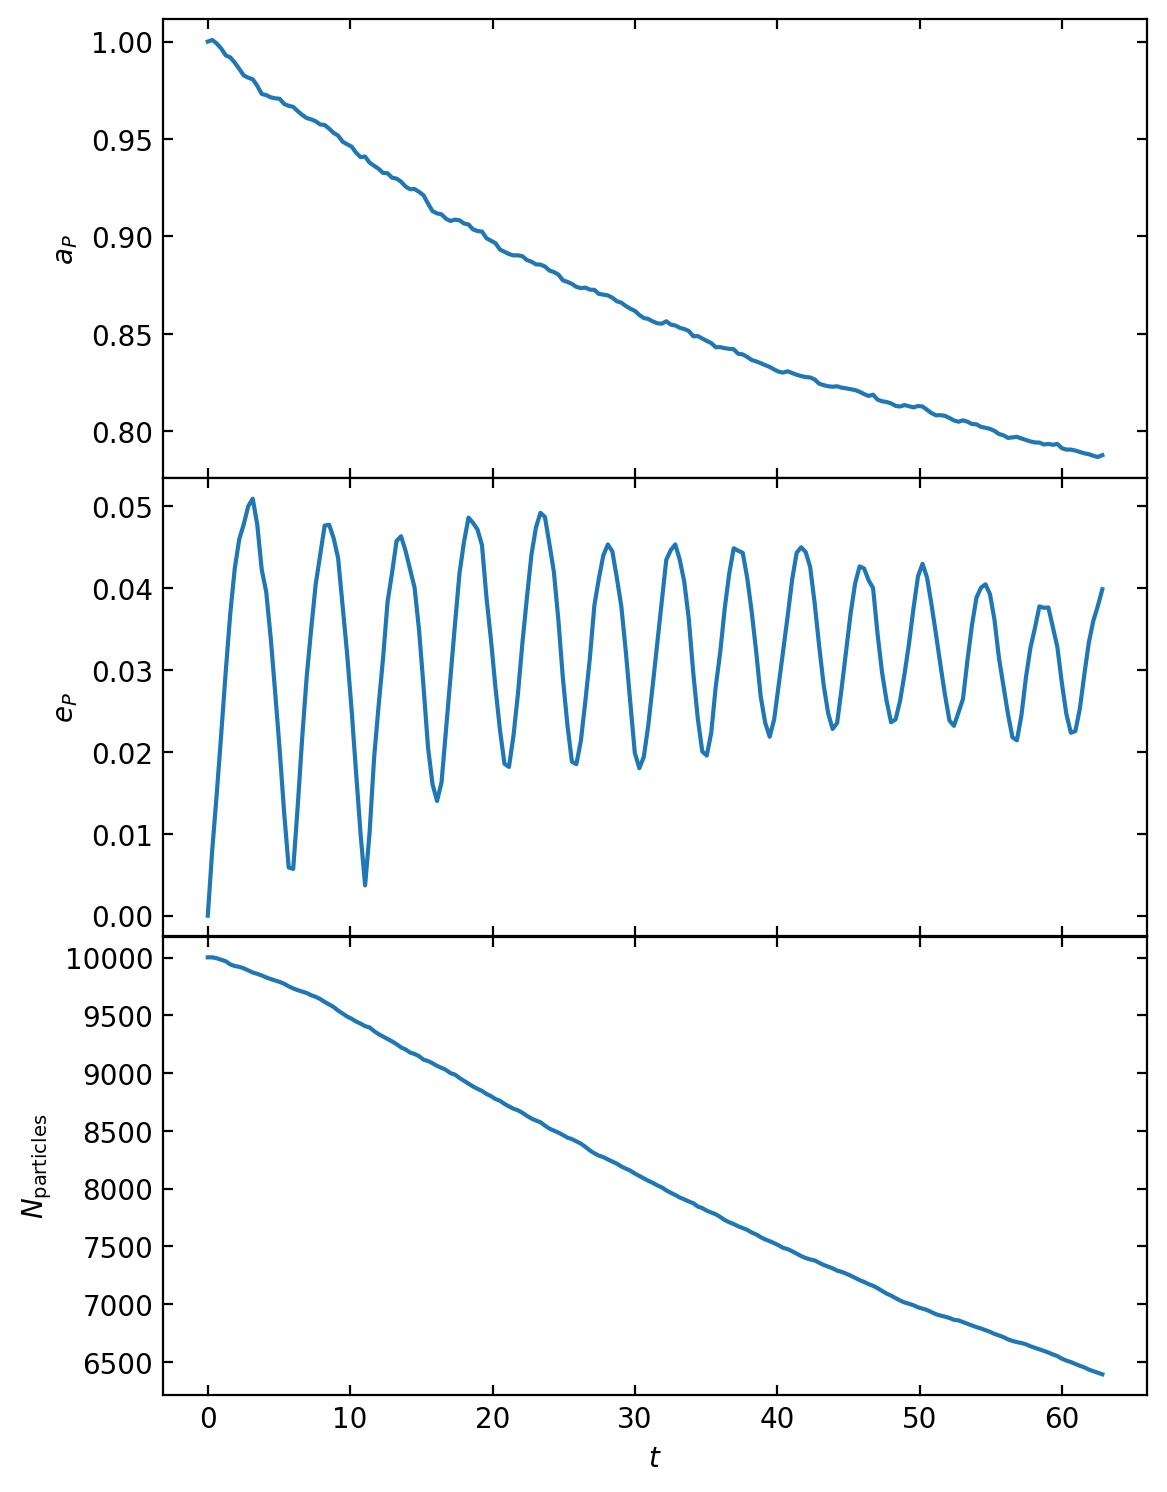

Total time = 339.393 s


In [8]:
start = time.time()

sim = rebound.Simulation()

# start the visualization server: in your browser go to http://localhost:1234
sim.start_server(port=1234)

# use a tree code since we will have many particles
sim.integrator = "leapfrog"
sim.gravity = "tree"
sim.dt = 0.01
# soften the interaction for close approaches
sim.softening = 0.01

# define a box size for the simulation and add "open" boundary conditions
# particles that leave the box will be removed
boxsize = 10
sim.configure_box(boxsize)
sim.boundary = "open"

# Star
# we'll use a hash to label it so we can find it later
sim.add(m=1, hash="star")

# Planet
mp = 1e-1
sim.add(m=mp, a=1.0, e=0.0, hash="planet")

# Planetesimals
Nparticles = 10000
m_tot = 1e-1
setup_spherical(N=Nparticles, mass=m_tot)

sim.move_to_com()

Noutputs = 200
Norbits = 10
times = np.linspace(0, Norbits * 2*np.pi, Noutputs)
dt = times[-1]/(Noutputs-1)
a = np.zeros(Noutputs)
e = np.zeros(Noutputs)
N = np.zeros(Noutputs)
for i,t in enumerate(times):
    sim.integrate(t, exact_finish_time=1)
    show_progress(i)
    # store the planet's orbit
    orb = sim.particles["planet"].orbit(primary=sim.particles["star"])
    a[i] = orb.a
    e[i] = orb.e
    N[i] = sim.N

# shut down the visualization server; this will stop it complaining next time we run the simulation
sim.stop_server(port=1234)
print('\nSim time = %.3f s' % (time.time()-start,))

# Show the time-evolution of the planet's orbit
fig = plt.figure(figsize=(6,8))
gs = GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1], hspace=0)
axes = []
for i in range(3):
    ax = fig.add_subplot(gs[i, 0], sharex=axes[0] if axes else None)
    axes.append(ax)
axes[0].plot(times, a)
axes[1].plot(times, e)
axes[2].plot(times, N)
axes[-1].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$a_P$')
axes[1].set_ylabel(r'$e_P$')
axes[2].set_ylabel(r'$N_\mathrm{particles}$')
fig.subplots_adjust(top=0.96, right=0.96, left=0.14, bottom=0.1)
axes[0].tick_params(labelbottom=False)
axes[1].tick_params(labelbottom=False)
plt.savefig('spherical.pdf')
plt.show()
plt.close()

print('Total time = %.3f s' % (time.time()-start,))

__Comparison with analytic prediction:__ The Chandrasekhar formula for dynamical friction gives a deceleration $\propto \rho M_p/v^2$, where $\rho$ is the mass density of planetesimals, $M_p$ is the planet mass, and $v$ is a typical relative velocity. In our case, the central star dominates the mass, so $v^2\sim GM_\star/r\propto M_\star$. Therefore, we expect the change in $a$ per orbital period to be $\propto (M_p/M_\star)(Nm/M_\star)$. (It is instructive to contrast this with the formula from the textbook, eqs. 19.41 and 19.42, which are for the case where the cluster is self-gravitating, without the central mass, so then $v^2 \propto Nm$, and the mass scaling is $\propto M_p/Nm$).